<a href="https://colab.research.google.com/github/Dutra-Apex/Timeframe_Analysis/blob/main/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This pipeline requires the following inputs from the user:

- A csv file continaing the timeseries data to be trained and analyzed on;
- The x and y prediction range, where x is the amount of data used to predict y days in the future;


The pipeline returns the following:
- A linear and LSTM model trained on x% of the data;
- A forceasting plot for the naive, linear and LSTM model;
- Multiple accuracy metrics evaulated on test set.

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import math
import random
import os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation, Dropout, Flatten, RepeatVector
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from google.colab import drive
plt.style.use('fivethirtyeight')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stock_data_2022 = '/content/drive/My Drive/Thesis - Dutra/data/stock_data/data_2022/'
stock_data_2023 = '/content/drive/My Drive/Thesis - Dutra/data/stock_data/data_2023/'

In [ ]:
cleaned_data = '/content/drive/My Drive/Thesis - Dutra/data/cleaned_data'
os.chdir(cleaned_data)

In [ ]:
final_df = pd.concat([data_2022_m, data_2023_m])

In [ ]:
final_df.to_csv('minute_2022_2023.csv')

In [ ]:
minute_stocks = pd.read_csv('minute_2022_2023.csv')
hourly_stocks = pd.read_csv('hourly_2022_2023.csv')
daily_stocks = pd.read_csv('daily_2022_2023.csv')

In [ ]:
btc_m = pd.read_csv('btc_minute.csv')
btc_h = pd.read_csv('btc_hourly.csv')
btc_d = pd.read_csv('btc_daily.csv')

In [ ]:
btc_m = btc_m[btc_m['DateTime']>'2019-12-31'].reset_index()
btc_h = btc_h[btc_h['DateTime']>'2019-12-31'].reset_index()
btc_d = btc_d[btc_d['DateTime']>'2019-12-31'].reset_index()

In [ ]:
btc_m = btc_m[btc_m['DateTime']>'2021-06-31'].reset_index()
btc_h = btc_h[btc_h['DateTime']>'2021-06-31'].reset_index()
btc_d = btc_d[btc_d['DateTime']>'2021-06-31'].reset_index()

In [ ]:
# User parameters:
x_range = 15
y_range = 5

test_size = 0.2

# batch_size = 30
# epochs = 30


# data = btc_h[btc_h['DateTime']>'2016-12-31'].reset_index()

data = daily_stocks
daily_data = daily_stocks

timeframe = 'hour'

stock = "\NQ"
datetime = 'DateTime'

SyntaxError: ignored

# Data Wrangling
 Used to pad missing values, and to get the daily and hourly frames from the minute data
 

## Padding missing values

In [ ]:
btc_m = pd.read_csv('btc_minute.csv')
eth_m = pd.read_csv('eth_minute.csv')
mon_m = pd.read_csv('mon_minute.csv')

In [ ]:
test = btc_m.set_index("timestamp")

In [ ]:
(test.index[1:]-test.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [ ]:
test = test.reindex(range(test.index[0],test.index[-1]+60,60),method='pad')

In [ ]:
(test.index[1:]-test.index[:-1]).value_counts().head()

60    4578728
Name: Unix_Timestamp, dtype: int64

## Get other time frames from minute

In [ ]:
market_open = pd.to_datetime('9:30:00').time()
market_close = pd.to_datetime('16:00:00').time()

clean_data = []
for i in list_data:
  i['DateTime'] = pd.to_datetime(i['TimeStamp'])
  time = pd.to_datetime(i['TimeStamp']).dt.time
  clean_data.append(i[(time < market_close) & (time >= market_open)])

In [ ]:
minute = []
for i in range(len(clean_data)):
  groupkey=pd.to_datetime(clean_data[i]['DateTime'].dt.strftime('%Y-%m-%d %H:%MM'))
  minute.append(clean_data[i].groupby(groupkey).agg({'TimeStamp':'first', 'SPY':'first','/NQ':'first',
                                    'MSFT':'first','AAPL':'first',
                                    '/RTY':'first'}))

In [ ]:
final_df = pd.concat(minute)

In [ ]:
final_df.head(5)

,TimeStamp,SPY,/NQ,MSFT,AAPL,/RTY
DateTime,,,,,,
2022-01-03 09:30:00,2022-01-03 09:30:02.000,476.320,16383.00,335.3500,177.850,2255.7
2022-01-03 09:31:00,2022-01-03 09:31:00.000,476.475,16408.00,336.2700,178.110,2261.5
2022-01-03 09:32:00,2022-01-03 09:32:00.000,476.690,16426.50,337.3000,178.810,2257.8
2022-01-03 09:33:00,2022-01-03 09:33:00.000,476.610,16433.25,336.7698,178.905,2261.6
2022-01-03 09:34:00,2022-01-03 09:34:00.000,476.920,16437.75,336.8300,178.940,2266.9


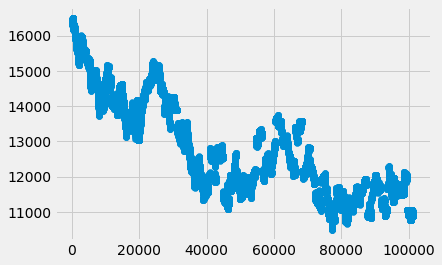

In [ ]:
plt.scatter(range(len(final_df)), final_df['/NQ'])

In [ ]:
final_df.to_csv('minute_data.csv')

In [ ]:
# Hourly
groupkey=pd.to_datetime(data_m['DateTime'].dt.strftime('%Y-%m-%d %H'))
data_h = data_m.groupby(groupkey).agg({'timestamp':'last', 'Open':'last','High':'last',
                                   'Low':'last','Close':'last',
                                   'Volume':'last','VWAP':'last',
                                   'Target':'last'})

In [ ]:
data_m = mon_m
name = 'mon'

In [ ]:
data_m['DateTime'] = pd.to_datetime(data_m['DateTime'])

In [ ]:
# Hourly
groupkey=pd.to_datetime(data_m['DateTime'].dt.strftime('%Y-%m-%d %H'))
data_h = data_m.groupby(groupkey).agg({'timestamp':'last', 'Open':'last','High':'last',
                                   'Low':'last','Close':'last',
                                   'Volume':'last','VWAP':'last',
                                   'Target':'last'})

In [ ]:
data_h[5000:5005]

,timestamp,Open,High,Low,Close,Volume,VWAP,Target
DateTime,,,,,,,,
2018-07-28 08:00:00,1532768280,140.30,140.30,140.17,140.30,20.000000,140.275036,0.001996
2018-07-28 09:00:00,1532771820,139.92,139.92,139.92,139.92,0.750000,139.920000,0.001859
2018-07-28 10:00:00,1532775540,141.30,141.39,141.30,141.39,47.150000,141.379502,-0.001414
2018-07-28 11:00:00,1532778780,140.59,141.34,140.59,140.59,42.101000,141.298958,0.009492
2018-07-28 12:00:00,1532782740,140.26,140.26,140.26,140.26,1.383528,140.260000,-0.000572


In [ ]:
data_h.to_csv(f'{name}_hourly.csv')

In [ ]:
# Daily
groupkey=pd.to_datetime(pd.to_datetime(minute_stocks['DateTime']).dt.strftime('%Y-%m-%d'))
data_d = minute_stocks.groupby(groupkey).agg({'TimeStamp':'last', 'SPY':'last','/NQ':'last',
                                    'MSFT':'last','AAPL':'last',
                                    '/RTY':'last'})

In [ ]:
data_d.to_csv('daily_2022_2023.csv')

In [ ]:
# Daily
groupkey=pd.to_datetime(data_m['DateTime'].dt.strftime('%Y-%m-%d'))
data_d = data_m.groupby(groupkey).agg({'timestamp':'last', 'Open':'last','High':'last',
                                   'Low':'last','Close':'last',
                                   'Volume':'last','VWAP':'last',
                                   'Target':'last'})

In [ ]:
data_d[200:205]

,timestamp,Open,High,Low,Close,Volume,VWAP,Target
DateTime,,,,,,,,
2018-07-20,1532131080,129.71,129.71,129.71,129.71,1.989998,129.710000,-0.000768
2018-07-21,1532217540,132.30,132.30,132.30,132.30,0.751000,132.300000,-0.005299
2018-07-22,1532303940,128.18,128.18,128.18,128.18,2.530428,128.180000,0.001482
2018-07-23,1532390100,133.51,133.51,133.30,133.46,72.545938,133.365513,0.002398
2018-07-24,1532476680,147.94,147.94,147.94,147.94,2.282000,147.940000,0.002231


In [ ]:
data_d.to_csv(f'{name}_daily.csv')

In [ ]:
del data_m

# Pipeline

## LSTM model

### Formatting data

In [ ]:
def x_y_split(x_range, y_range, data, daily_data, timeframe, datetime, column, market_hours=False):
  
  if timeframe == 'day':
    x_len = x_range
  elif timeframe == 'hour':
    if market_hours:
      x_len = 8 * x_range
    else:
      x_len = 24 * x_range
  elif timeframe == 'minute':
    if market_hours:
      x_len = 60 * 8 * x_range
    else:
      x_len = 60 * 24 * x_range
  
  x = np.zeros((len(data)-1-x_len, x_len))
  y = np.zeros((len(data)-1-x_len, y_range))
  y_date = pd.to_datetime(data[datetime][x_len])
  for i in range(0, len(data)-x_len-1):
    temp_x, temp_y = [], []

    # for j in range(x_len):
    #   temp_x.append(data[column][i+j])
    temp_x = data[column][i:i+x_len]
    y_date = pd.to_datetime(data[datetime][i+x_len])
    
    while len(temp_y) < y_range:
      temp = daily_data[daily_data[datetime] == y_date.strftime("%Y-%m-%d")][column]
      temp = np.array(temp)
      if len(temp) != 0:
        temp_y.append(temp[0])
      if y_date < pd.to_datetime(daily_data[datetime][len(daily_data)-1]):
        y_date += pd.Timedelta(days=1)
      else:
        if len(temp_y) < y_range:
          temp_y.append(daily_data[column][len(daily_data)-1])


    # print(temp_x)
    # print(temp_y)
    # x.append(np.array(temp_x))
    # y.append(np.array(temp_y))
    x[i] += temp_x
    y[i] += temp_y

  return x, y

In [ ]:
x, y = x_y_split(x_range, y_range, data, daily_data, timeframe, datetime, stock, market_hours=True)

KeyError: ignored

In [ ]:
# Split data into training and testing
x_train, x_test = train_test_split(x, test_size=test_size, shuffle=False)
y_train, y_test = train_test_split(y, test_size=test_size, shuffle=False)

In [ ]:
# Given an x and y set, scales the data between a and b
def scale_data(x, y, a, b):
  min_ = min(np.amin(x), np.amin(y))
  max_ = max(np.amax(x), np.amax(y))
  x_scaled = (x - min_) / (max_ - min_) * (b - a) + a
  y_scaled = (y - min_) / (max_ - min_) * (b - a) + a
  return x_scaled, y_scaled, max_, min_

In [ ]:
x_train, y_train, max_train, min_train = scale_data(x_train, y_train, 0, 1)
x_test, y_test, max_test, min_test = scale_data(x_test, y_test, 0, 1)

In [ ]:
# Reshapes the data for LSTM training
# LSTM expects output in the form of (n_samples, timesteps, features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],  1) 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1) 
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1],  1) 
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1) 

### Training

In [ ]:
# Clears the backend before training
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
# model.add(LSTM(x_range, return_sequences=True))
model.add(LSTM(y_range, return_sequences=False,  
               stateful=True))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(x_train, y_train, epochs=5, batch_size=1, shuffle=False)

Epoch 1/5
151/151 [==============================] - 3s 7ms/step - loss: 0.0312
Epoch 2/5
151/151 [==============================] - 1s 7ms/step - loss: 0.0122
Epoch 3/5
151/151 [==============================] - 1s 6ms/step - loss: 0.0123
Epoch 4/5
151/151 [==============================] - 1s 5ms/step - loss: 0.0117
Epoch 5/5
151/151 [==============================] - 1s 5ms/step - loss: 0.0112


In [ ]:
tf.keras.models.save_model(model, 'minute_btc.h5')

In [ ]:
pred = []
for i in range(0, len(x_test)):
  pred.append(model.predict(tf.convert_to_tensor(x_test[i:i+1]), verbose=0)) 

In [ ]:
pred = np.array(pred)
pred = pred.reshape((pred.shape[0], pred.shape[-1]))

In [ ]:
def remove_sliding_window(data, pred):
  y, p = [], []
  for i in range(0, len(data)-1, y_range):
    if not np.array_equal(data[i], data[i+1]):
      y.append(data[i])
      p.append(pred[i])
  y = np.array(y)
  p = np.array(p)
  return y.flatten(), p.flatten()

In [ ]:
y_ ,p_ = remove_sliding_window(y_test, pred)

In [ ]:
def reverse_scale(x, a, b, min_, max_):
  x_r = x * (max_ - min_) + min_
  return x_r

In [ ]:
actual_vals = reverse_scale(y_, 0, 1, min_test, max_test)
pred_vals = reverse_scale(p_, 0, 1, min_test, max_test)

In [ ]:
def plot_preds(actual, pred, timeframe, column):
  plt.figure(figsize=(16, 8))
  plt.grid(False)
  plt.plot(actual, label='Actual')
  plt.plot(pred, label='Forecast')
  plt.legend()
  plt.xlabel('Days')
  plt.ylabel('Price ($)')
  plt.title(f'Actual vs forecast price of {column} ({timeframe})')
  plt.show()

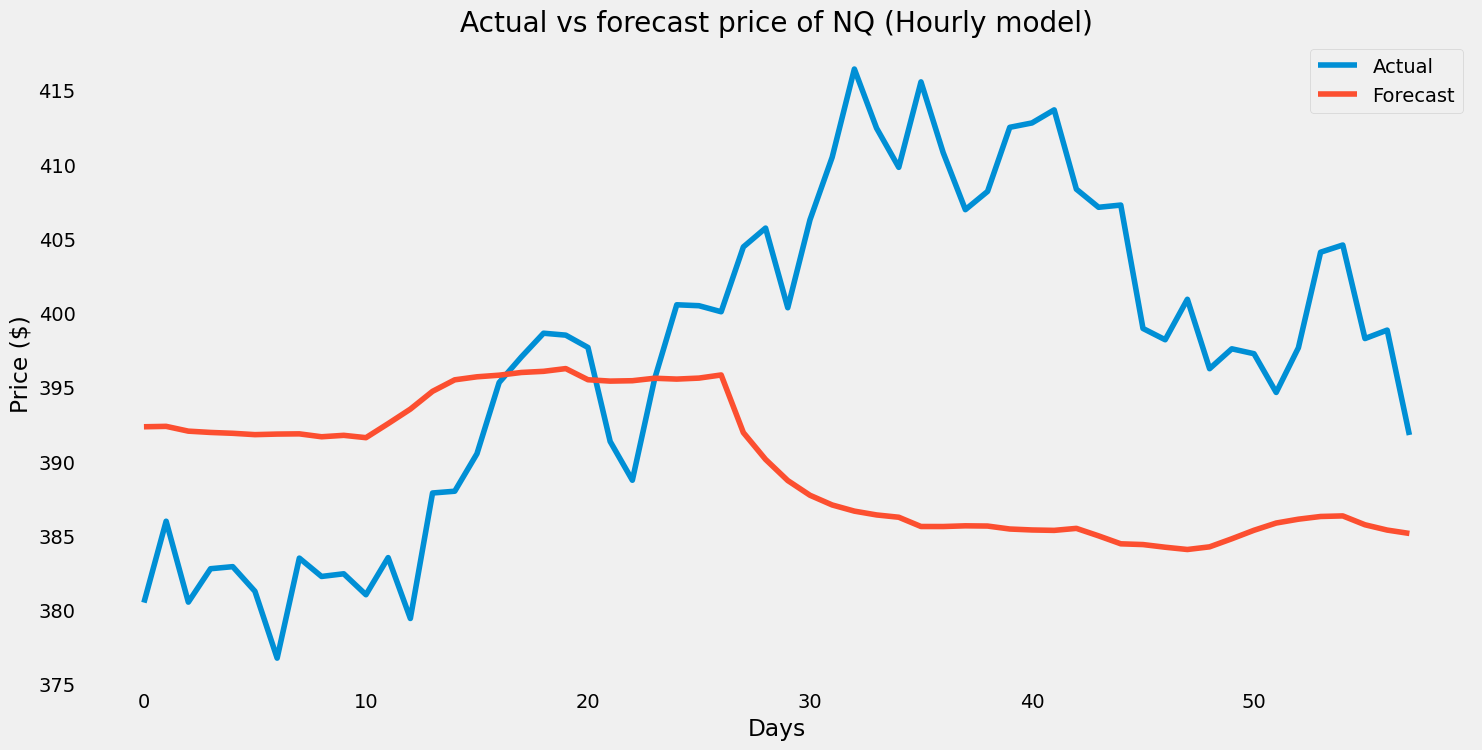

In [ ]:
plot_preds(actual_vals, pred_vals, 'Hourly model' , stock)

### Evaluating accuracy

In [ ]:
# Defines all the accuracy metrics to be used in the analysis
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def mse(a, f):
  return math.sqrt(mean_squared_error(a, f))

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

def getTradingSignals(pred, actual):
  signals = []
  i, j = 0, 1
  while j < len(pred):
    if actual[j] > pred[i]:
      signals.append(1)
    elif actual[j] < pred[i]:
      signals.append(-1)
    else:
      signals.append(0)
    j += 1
    i += 1

  return signals

def getTrendSimilarity(actual, forecast):
    actual_signals = getTradingSignals(actual, threshold, actual)
    forecast_signals = getTradingSignals(forecast, threshold, forecast)
    trend_similarity = 0
    for i in range(len(actual_signals)):
      if actual_signals[i] == forecast_signals[i]:
        trend_similarity += 1

    trend_similarity = abs(len(actual_signals) - trend_similarity)
    trend_similarity = (1 - trend_similarity/len(actual_signals)) * 100
    return trend_similarity

In [ ]:
def get_acc_metrics(actual, pred):
  list_acc = []
  list_acc.append(mae(actual, pred))
  list_acc.append(mse(actual, pred))
  list_acc.append(smape(actual, pred))
  list_acc.append(getTrendSimilarity(actual, pred))
  print('MAE', mae(actual, pred))
  print('MSE', mse(actual, pred))
  print('sMAPE', smape(actual, pred))
  print('Trend Similarity', getTrendSimilarity(actual, pred))
  return list_acc